In [34]:
import gym

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

from collections import namedtuple
import random

#for easily accessing (s, a, r, s') tuples
Transition = namedtuple("Transition", "state, action, reward, next_state")

In [51]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity if capacity > 1 else 1
        self.pos = 0
        self.memory = []

    def push(self, *args):
        #expand array
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.capacity

    def sample_mini_batch(self, bs):
        return random.sample(self.memory, bs)

    def __len__(self):
        return len(self.memory)

class SimpleFCModel(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs
        self.lin1 = nn.Linear(inputs, 30)
        self.lin2 = nn.Linear(30, 20)
        self.lin3 = nn.Linear(20, outputs)

    def forward(self, xb):
        x = F.relu(self.lin1(xb))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

# gym.envs.register(
#     id="CartPole10000-v0",
#     entry_point='gym.envs.classic_control:CartPoleEnv',
#     max_episode_steps=10000,
# )

In [52]:
env = gym.make("CartPole-v0")

GAMMA = 0.999
EPSILON_DECAY_DURATION = 200
EPSILON_MAX = 0.9
EPSILON_MIN = 0.05
BATCH_SIZE = 256

def weights_init(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        nn.init.normal_(module.bias, 0, 0.02)

In [53]:
policy_net = SimpleFCModel(env.observation_space.shape[0], env.action_space.n).float()
policy_net.apply(weights_init)
target_net = SimpleFCModel(env.observation_space.shape[0], env.action_space.n).float()
target_net.load_state_dict(policy_net.state_dict())

memory = ReplayMemory(4000)

steps_done = 0
rand_count = 0
policy_count = 0

optimizer = optim.Adam(policy_net.parameters(), lr=0.005)

In [54]:
def clamp(val, min_v, max_v):
    if val < min_v:
        return min_v
    elif val > max_v:
        return max_v
    else:
        return val

In [55]:
def select_action(state):
    global steps_done
    global rand_count
    global policy_count
    r = random.random()

    threshold = clamp(EPSILON_MIN + (steps_done  * (EPSILON_MAX - EPSILON_MIN) / EPSILON_DECAY_DURATION), 0.0, 1.0)

    if r < threshold:
        with torch.no_grad():
            policy_count += 1
            return int(policy_net(state).argmax())
    else:
        rand_count += 1
        return env.action_space.sample()

In [56]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        print("not enough stuff in memory")
        return

    transitions = memory.sample_mini_batch(BATCH_SIZE)

    #splat operator, for getting states, actions, rewards, next states separately
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.tensor(batch.state, dtype=torch.float)
    state_max = state_batch.max(1)[0].max(0)[0]
    action_batch = torch.tensor(batch.action, dtype=torch.long)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch.view(-1, 1))

    #next state values
    #zero for terminal states
    #argmax of Q values of next state for non terminal
    next_state_values = torch.zeros(BATCH_SIZE)

    non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.uint8)
    non_terminal_states = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float)

    next_state_values[non_terminal_mask] = target_net(non_terminal_states).max(1)[0].detach()

    expected_q_values = reward_batch + GAMMA * next_state_values

    loss = F.mse_loss(state_action_values, expected_q_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()

In [57]:
from itertools import count

def show_episode(env, model):
    state = env.reset()
    for t in count():
        with torch.no_grad():
            action = int(
                model(torch.tensor(state, dtype=torch.float)).argmax()
            )

        obs, reward, done, _ = env.step(action)

#         env.render()

        if done:
            print("episode duration: {}".format(t))
            break
        else:
            state = obs

In [58]:
TARGET_UPDATE = 10
SHOW_EPISODE = 50
max_loss_here = 0

durations = []

def run_episode(episode, print_every=10):
    global rand_count
    global policy_count
    global steps_done

    rand_count = 0
    policy_count = 0

    state = env.reset()
    max_loss_here = 0

    for t in count():
        # print(state)
        action = select_action(torch.tensor(state, dtype=torch.float))

        obs, reward, done, _ = env.step(action)

        if not done:
            next_state = obs
        else:
            next_state = None

        memory.push(state, action, reward, next_state)

        state = next_state

        loss = optimize_model()

        if loss is not None:
            if max_loss_here < loss:
                max_loss_here = loss
        
        if done:
            print("episode#{} duration: {}".format(episode, t))
            print("random count: {}\tpolicy count:{}".format(rand_count, policy_count))
            durations.append(t)
            break

    print("max loss in episode {}: {}".format(episode, max_loss_here))
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if episode % SHOW_EPISODE == 0:
        show_episode(env, target_net)

In [59]:
#run episodes

num_episodes = 500
for episode in range(num_episodes):
    run_episode(episode)
    steps_done += 1

env.close()

not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
episode#0 duration: 11
random count: 11	policy count:1
max loss in episode 0: 0
episode duration: 43
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enough stuff in memory
not enou

episode#17 duration: 9
random count: 8	policy count:2
max loss in episode 17: 0.1577455848455429
episode#18 duration: 16
random count: 17	policy count:0
max loss in episode 18: 0.14926083385944366
episode#19 duration: 11
random count: 11	policy count:1
max loss in episode 19: 0.1704390048980713
episode#20 duration: 19
random count: 19	policy count:1
max loss in episode 20: 0.1643887758255005
episode#21 duration: 12
random count: 8	policy count:5
max loss in episode 21: 1.3934978246688843
episode#22 duration: 12
random count: 9	policy count:4
max loss in episode 22: 0.42827579379081726
episode#23 duration: 14
random count: 13	policy count:2
max loss in episode 23: 0.3940005600452423
episode#24 duration: 11
random count: 10	policy count:2
max loss in episode 24: 0.29279226064682007
episode#25 duration: 13
random count: 12	policy count:2
max loss in episode 25: 0.27711033821105957
episode#26 duration: 13
random count: 12	policy count:2
max loss in episode 26: 0.2858319580554962
episode#27

episode#100 duration: 30
random count: 15	policy count:16
max loss in episode 100: 0.34840524196624756
episode duration: 199
episode#101 duration: 48
random count: 28	policy count:21
max loss in episode 101: 1.0995209217071533
episode#102 duration: 75
random count: 41	policy count:35
max loss in episode 102: 0.26292309165000916
episode#103 duration: 99
random count: 49	policy count:51
max loss in episode 103: 0.33352357149124146
episode#104 duration: 16
random count: 9	policy count:8
max loss in episode 104: 0.13321484625339508
episode#105 duration: 135
random count: 71	policy count:65
max loss in episode 105: 0.36185410618782043
episode#106 duration: 76
random count: 46	policy count:31
max loss in episode 106: 0.40617507696151733
episode#107 duration: 106
random count: 48	policy count:59
max loss in episode 107: 0.24526585638523102
episode#108 duration: 109
random count: 53	policy count:57
max loss in episode 108: 0.3194628357887268
episode#109 duration: 101
random count: 59	policy co

episode#180 duration: 96
random count: 16	policy count:81
max loss in episode 180: 1.7238954305648804
episode#181 duration: 42
random count: 8	policy count:35
max loss in episode 181: 2.076291561126709
episode#182 duration: 199
random count: 29	policy count:171
max loss in episode 182: 1.9682495594024658
episode#183 duration: 31
random count: 6	policy count:26
max loss in episode 183: 2.541280746459961
episode#184 duration: 160
random count: 23	policy count:138
max loss in episode 184: 2.464867353439331
episode#185 duration: 30
random count: 5	policy count:26
max loss in episode 185: 1.901792287826538
episode#186 duration: 91
random count: 15	policy count:77
max loss in episode 186: 2.706423044204712
episode#187 duration: 54
random count: 6	policy count:49
max loss in episode 187: 2.595733642578125
episode#188 duration: 41
random count: 4	policy count:38
max loss in episode 188: 2.420474052429199
episode#189 duration: 18
random count: 5	policy count:14
max loss in episode 189: 3.090220

episode#261 duration: 111
random count: 0	policy count:112
max loss in episode 261: 3.530332326889038
episode#262 duration: 130
random count: 0	policy count:131
max loss in episode 262: 2.70169734954834
episode#263 duration: 134
random count: 0	policy count:135
max loss in episode 263: 7.072051525115967
episode#264 duration: 153
random count: 0	policy count:154
max loss in episode 264: 5.386319637298584
episode#265 duration: 127
random count: 0	policy count:128
max loss in episode 265: 4.260956764221191
episode#266 duration: 167
random count: 0	policy count:168
max loss in episode 266: 3.9037058353424072
episode#267 duration: 199
random count: 0	policy count:200
max loss in episode 267: 4.811657428741455
episode#268 duration: 47
random count: 0	policy count:48
max loss in episode 268: 5.115914821624756
episode#269 duration: 39
random count: 0	policy count:40
max loss in episode 269: 3.4926226139068604
episode#270 duration: 199
random count: 0	policy count:200
max loss in episode 270: 5

episode#341 duration: 195
random count: 0	policy count:196
max loss in episode 341: 8.70642375946045
episode#342 duration: 199
random count: 0	policy count:200
max loss in episode 342: 6.732008457183838
episode#343 duration: 184
random count: 0	policy count:185
max loss in episode 343: 7.796454906463623
episode#344 duration: 197
random count: 0	policy count:198
max loss in episode 344: 6.280026912689209
episode#345 duration: 199
random count: 0	policy count:200
max loss in episode 345: 3.1003496646881104
episode#346 duration: 199
random count: 0	policy count:200
max loss in episode 346: 2.500577688217163
episode#347 duration: 199
random count: 0	policy count:200
max loss in episode 347: 2.052135944366455
episode#348 duration: 195
random count: 0	policy count:196
max loss in episode 348: 1.9873735904693604
episode#349 duration: 199
random count: 0	policy count:200
max loss in episode 349: 1.915811538696289
episode#350 duration: 199
random count: 0	policy count:200
max loss in episode 35

episode#421 duration: 199
random count: 0	policy count:200
max loss in episode 421: 2.418180465698242
episode#422 duration: 199
random count: 0	policy count:200
max loss in episode 422: 2.317249059677124
episode#423 duration: 199
random count: 0	policy count:200
max loss in episode 423: 2.127265691757202
episode#424 duration: 199
random count: 0	policy count:200
max loss in episode 424: 2.847710132598877
episode#425 duration: 199
random count: 0	policy count:200
max loss in episode 425: 2.1763980388641357
episode#426 duration: 199
random count: 0	policy count:200
max loss in episode 426: 2.6455445289611816
episode#427 duration: 199
random count: 0	policy count:200
max loss in episode 427: 2.1154348850250244
episode#428 duration: 199
random count: 0	policy count:200
max loss in episode 428: 2.480217218399048
episode#429 duration: 33
random count: 0	policy count:34
max loss in episode 429: 9.92695426940918
episode#430 duration: 40
random count: 0	policy count:41
max loss in episode 430: 

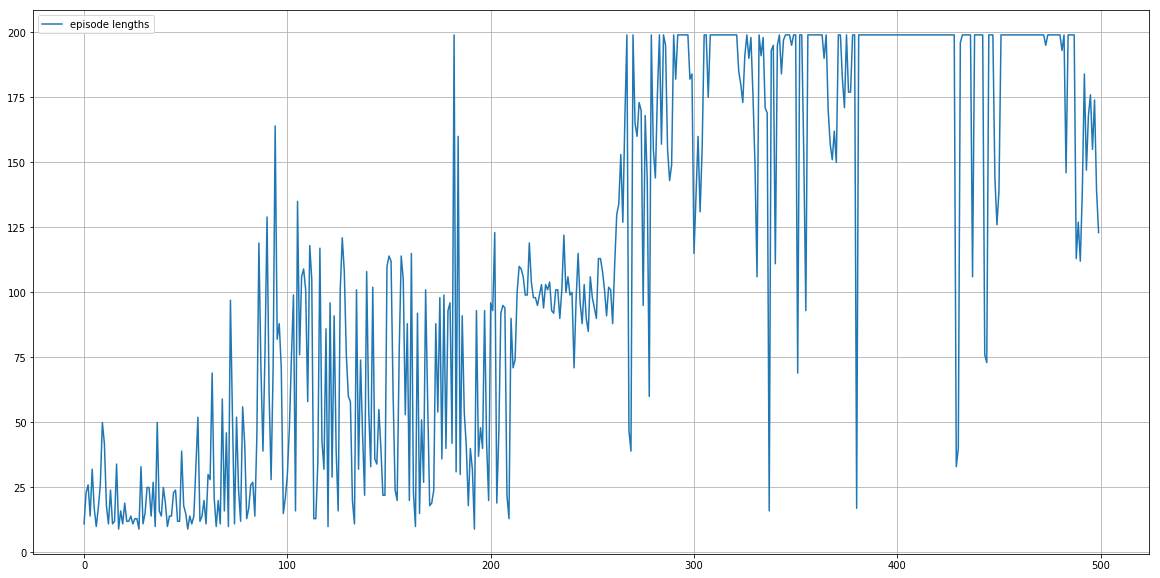

In [62]:
def plot_durations():
    plt.figure(figsize=[20, 10])
    plt.plot(durations, label="episode lengths")
    plt.grid(b=True, which='both')
    plt.legend(loc='upper left')
    plt.show()

plot_durations()